Label Image 에서 생성한 json 파일로 새로운 yolo dataset 들을 만든다


In [1]:
import os
import numpy as np
import pandas as pd
import json
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

In [39]:
mask_model_ver = 132508

DATA_DIR = "/root/autodl-tmp/cervical_spine/"
IMAGES_DIR = os.path.join(DATA_DIR, 'yolo/images/')
LABELS_DIR = os.path.join(DATA_DIR, 'yolo/labels/')

BBOX_PATH = os.path.join(DATA_DIR, 'lm_labels/project-6-at-2022-10-24-13-58-7378271a.json')

In [40]:
with open(BBOX_PATH) as json_file:
    bbox_data = json.load(json_file)

In [41]:
len(bbox_data)

7201

In [43]:
train_df = pd.DataFrame()
for data in tqdm(bbox_data):
    image = data['data']['image']
    UID = image.split('/')[-2]
    Slice = image.split('/')[-1].replace('.jpeg','')
    
    if len(data['annotations'][0]['result']) == 0:
        continue
    bbox = data['annotations'][0]['result'][0]['value']
    
    # coord = [bbox['x'], bbox['y'], bbox['width'], bbox['height']]
    
    new_s = pd.Series(data={
        'UID' : UID,
        'axial_index' : Slice,
        'x' : bbox['x'] * 5.12,
        'y' : bbox['y'] * 5.12,
        'width' : bbox['width'] * 5.12,
        'height' : bbox['height'] * 5.12
    })
    
    train_df = pd.concat((train_df, new_s.to_frame().T), axis=0)

train_df = train_df.sort_values(['UID','axial_index']).reset_index(drop=True)
print(len(train_df.UID.unique()))
print(len(train_df))
train_df.head()

100%|██████████| 7201/7201 [00:04<00:00, 1449.35it/s]

234
7189


,UID,axial_index,x,y,width,height
0,1.2.826.0.1.3680043.10051,132,219.27715,216.71419,17.3044,20.38517
1,1.2.826.0.1.3680043.10051,133,221.5646,216.71419,17.87844,25.24362
2,1.2.826.0.1.3680043.10051,134,216.82151,221.62546,27.00959,26.37454
3,1.2.826.0.1.3680043.10051,135,214.49455,215.48637,27.92726,37.51363
4,1.2.826.0.1.3680043.10051,136,214.0,215.48637,27.0,43.51363


In [44]:
train_df['UID_Slice'] = train_df['UID'] + '.' + train_df['axial_index'].astype('string')
train_df = train_df.set_index('UID_Slice').astype({'axial_index': int})
print(len(train_df))
train_df.head()

7189


,UID,axial_index,x,y,width,height
UID_Slice,,,,,,
1.2.826.0.1.3680043.10051.132,1.2.826.0.1.3680043.10051,132,219.27715,216.71419,17.3044,20.38517
1.2.826.0.1.3680043.10051.133,1.2.826.0.1.3680043.10051,133,221.5646,216.71419,17.87844,25.24362
1.2.826.0.1.3680043.10051.134,1.2.826.0.1.3680043.10051,134,216.82151,221.62546,27.00959,26.37454
1.2.826.0.1.3680043.10051.135,1.2.826.0.1.3680043.10051,135,214.49455,215.48637,27.92726,37.51363
1.2.826.0.1.3680043.10051.136,1.2.826.0.1.3680043.10051,136,214.0,215.48637,27.0,43.51363


In [45]:
total_boundary_df = pd.read_csv(os.path.join(DATA_DIR, f'infered_boundary_{mask_model_ver}_2.csv'))
total_boundary_df['UID_Slice'] = total_boundary_df['StudyInstanceUID'] + '.' + total_boundary_df['Slice'].astype('string')
total_boundary_df = total_boundary_df.set_index('UID_Slice').astype({'Slice': int})
print(len(total_boundary_df))
total_boundary_df.head()

708779


,StudyInstanceUID,Slice,Start,pixel_spacing,xmin,ymin,xmax,ymax
UID_Slice,,,,,,,,
1.2.826.0.1.3680043.10001.0,1.2.826.0.1.3680043.10001,0,0,0.253906,0.0,0.0,512.0,512.0
1.2.826.0.1.3680043.10001.1,1.2.826.0.1.3680043.10001,1,0,0.253906,0.0,0.0,512.0,512.0
1.2.826.0.1.3680043.10001.2,1.2.826.0.1.3680043.10001,2,0,0.253906,0.0,0.0,512.0,512.0
1.2.826.0.1.3680043.10001.3,1.2.826.0.1.3680043.10001,3,0,0.253906,0.0,0.0,512.0,512.0
1.2.826.0.1.3680043.10001.4,1.2.826.0.1.3680043.10001,4,0,0.253906,0.0,0.0,512.0,512.0


In [46]:
train_boundary_df = total_boundary_df[total_boundary_df.StudyInstanceUID.isin(train_df.UID.unique())]
train_boundary_df = train_boundary_df[['Start','Slice', 'StudyInstanceUID','xmin','ymin','xmax','ymax']]
print(len(train_boundary_df))
train_boundary_df.head()

77339


,Start,Slice,StudyInstanceUID,xmin,ymin,xmax,ymax
UID_Slice,,,,,,,
1.2.826.0.1.3680043.10051.0,0,0,1.2.826.0.1.3680043.10051,0.0,0.0,512.0,512.0
1.2.826.0.1.3680043.10051.1,0,1,1.2.826.0.1.3680043.10051,0.0,0.0,512.0,512.0
1.2.826.0.1.3680043.10051.2,0,2,1.2.826.0.1.3680043.10051,0.0,0.0,512.0,512.0
1.2.826.0.1.3680043.10051.3,0,3,1.2.826.0.1.3680043.10051,0.0,0.0,512.0,512.0
1.2.826.0.1.3680043.10051.4,0,4,1.2.826.0.1.3680043.10051,0.0,0.0,512.0,512.0


In [47]:
total_df = pd.concat((train_boundary_df, train_df), axis=1)
print(len(total_df))
total_df.iloc[130:140]

77339


,Start,Slice,StudyInstanceUID,xmin,ymin,xmax,ymax,UID,axial_index,x,y,width,height
UID_Slice,,,,,,,,,,,,,
1.2.826.0.1.3680043.10051.130,0,130,1.2.826.0.1.3680043.10051,45.076729,0.0,438.923271,393.846542,NaN,NaN,NaN,NaN,NaN,NaN
1.2.826.0.1.3680043.10051.131,0,131,1.2.826.0.1.3680043.10051,47.076729,0.0,440.923271,393.846542,NaN,NaN,NaN,NaN,NaN,NaN
1.2.826.0.1.3680043.10051.132,0,132,1.2.826.0.1.3680043.10051,43.076729,0.0,436.923271,393.846542,1.2.826.0.1.3680043.10051,132.0,219.27715,216.71419,17.3044,20.38517
1.2.826.0.1.3680043.10051.133,0,133,1.2.826.0.1.3680043.10051,36.076729,0.0,429.923271,393.846542,1.2.826.0.1.3680043.10051,133.0,221.5646,216.71419,17.87844,25.24362
1.2.826.0.1.3680043.10051.134,0,134,1.2.826.0.1.3680043.10051,45.076729,0.0,438.923271,393.846542,1.2.826.0.1.3680043.10051,134.0,216.82151,221.62546,27.00959,26.37454
1.2.826.0.1.3680043.10051.135,0,135,1.2.826.0.1.3680043.10051,41.076729,0.0,434.923271,393.846542,1.2.826.0.1.3680043.10051,135.0,214.49455,215.48637,27.92726,37.51363
1.2.826.0.1.3680043.10051.136,0,136,1.2.826.0.1.3680043.10051,28.076729,0.0,421.923271,393.846542,1.2.826.0.1.3680043.10051,136.0,214.0,215.48637,27.0,43.51363
1.2.826.0.1.3680043.10051.137,0,137,1.2.826.0.1.3680043.10051,12.076729,0.0,405.923271,393.846542,1.2.826.0.1.3680043.10051,137.0,213.56364,216.71419,25.13455,47.92717
1.2.826.0.1.3680043.10051.138,0,138,1.2.826.0.1.3680043.10051,31.076729,0.0,424.923271,393.846542,1.2.826.0.1.3680043.10051,138.0,209.0,214.57591,36.06131,51.56834


In [48]:
total_df[['cx','cy']] = total_df[['x', 'y']].values - total_df[['xmin','ymin']].values
total_df[['img_width', 'img_height']] = total_df[['xmax','ymax']].values - total_df[['xmin','ymin']].values


total_df["xcenter"] = (total_df["cx"].values + (total_df["width"].values / 2)) / total_df["img_width"].values
total_df["ycenter"] = (total_df["cy"].values + (total_df["height"].values / 2)) / total_df["img_height"].values
total_df["width_norm"] = total_df["width"].values / total_df["img_width"].values
total_df["height_norm"] = total_df["height"].values / total_df["img_height"].values

total_df.iloc[130:140]

,Start,Slice,StudyInstanceUID,xmin,ymin,xmax,ymax,UID,axial_index,x,...,width,height,cx,cy,img_width,img_height,xcenter,ycenter,width_norm,height_norm
UID_Slice,,,,,,,,,,,,,,,,,,,,,
1.2.826.0.1.3680043.10051.130,0,130,1.2.826.0.1.3680043.10051,45.076729,0.0,438.923271,393.846542,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,393.846542,393.846542,NaN,NaN,NaN,NaN
1.2.826.0.1.3680043.10051.131,0,131,1.2.826.0.1.3680043.10051,47.076729,0.0,440.923271,393.846542,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,393.846542,393.846542,NaN,NaN,NaN,NaN
1.2.826.0.1.3680043.10051.132,0,132,1.2.826.0.1.3680043.10051,43.076729,0.0,436.923271,393.846542,1.2.826.0.1.3680043.10051,132.0,219.27715,...,17.3044,20.38517,176.200421,216.71419,393.846542,393.846542,0.469352,0.57613,0.043937,0.051759
1.2.826.0.1.3680043.10051.133,0,133,1.2.826.0.1.3680043.10051,36.076729,0.0,429.923271,393.846542,1.2.826.0.1.3680043.10051,133.0,221.5646,...,17.87844,25.24362,185.487871,216.71419,393.846542,393.846542,0.493662,0.582298,0.045394,0.064095
1.2.826.0.1.3680043.10051.134,0,134,1.2.826.0.1.3680043.10051,45.076729,0.0,438.923271,393.846542,1.2.826.0.1.3680043.10051,134.0,216.82151,...,27.00959,26.37454,171.744781,221.62546,393.846542,393.846542,0.47036,0.596204,0.068579,0.066967
1.2.826.0.1.3680043.10051.135,0,135,1.2.826.0.1.3680043.10051,41.076729,0.0,434.923271,393.846542,1.2.826.0.1.3680043.10051,135.0,214.49455,...,27.92726,37.51363,173.417821,215.48637,393.846542,393.846542,0.475773,0.594758,0.070909,0.095249
1.2.826.0.1.3680043.10051.136,0,136,1.2.826.0.1.3680043.10051,28.076729,0.0,421.923271,393.846542,1.2.826.0.1.3680043.10051,136.0,214.0,...,27.0,43.51363,185.923271,215.48637,393.846542,393.846542,0.506348,0.602375,0.068555,0.110484
1.2.826.0.1.3680043.10051.137,0,137,1.2.826.0.1.3680043.10051,12.076729,0.0,405.923271,393.846542,1.2.826.0.1.3680043.10051,137.0,213.56364,...,25.13455,47.92717,201.486911,216.71419,393.846542,393.846542,0.543496,0.611095,0.063818,0.12169
1.2.826.0.1.3680043.10051.138,0,138,1.2.826.0.1.3680043.10051,31.076729,0.0,424.923271,393.846542,1.2.826.0.1.3680043.10051,138.0,209.0,...,36.06131,51.56834,177.923271,214.57591,393.846542,393.846542,0.497539,0.610289,0.091562,0.130935


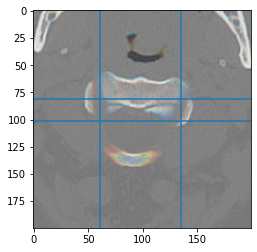

In [50]:
UID_Slice = '1.2.826.0.1.3680043.13444.128'
s = total_df.loc[UID_Slice]
img = Image.open(os.path.join(IMAGES_DIR, s.StudyInstanceUID, f'{s.Slice}.jpeg'))
plt.imshow(img)
plt.axvline(s.cx)
plt.axhline(s.cy)
plt.axvline(s.cx + s.width)
plt.axhline(s.cy + s.height)

In [51]:
total_df['img_path'] = IMAGES_DIR + total_df['StudyInstanceUID'] + '/' + total_df['Slice'].astype('string') + '.jpeg'
total_df.iloc[130:135]

,Start,Slice,StudyInstanceUID,xmin,ymin,xmax,ymax,UID,axial_index,x,...,height,cx,cy,img_width,img_height,xcenter,ycenter,width_norm,height_norm,img_path
UID_Slice,,,,,,,,,,,,,,,,,,,,,
1.2.826.0.1.3680043.10051.130,0,130,1.2.826.0.1.3680043.10051,45.076729,0.0,438.923271,393.846542,NaN,NaN,NaN,...,NaN,NaN,NaN,393.846542,393.846542,NaN,NaN,NaN,NaN,/root/autodl-tmp/cervical_spine/yolo/images/1....
1.2.826.0.1.3680043.10051.131,0,131,1.2.826.0.1.3680043.10051,47.076729,0.0,440.923271,393.846542,NaN,NaN,NaN,...,NaN,NaN,NaN,393.846542,393.846542,NaN,NaN,NaN,NaN,/root/autodl-tmp/cervical_spine/yolo/images/1....
1.2.826.0.1.3680043.10051.132,0,132,1.2.826.0.1.3680043.10051,43.076729,0.0,436.923271,393.846542,1.2.826.0.1.3680043.10051,132.0,219.27715,...,20.38517,176.200421,216.71419,393.846542,393.846542,0.469352,0.57613,0.043937,0.051759,/root/autodl-tmp/cervical_spine/yolo/images/1....
1.2.826.0.1.3680043.10051.133,0,133,1.2.826.0.1.3680043.10051,36.076729,0.0,429.923271,393.846542,1.2.826.0.1.3680043.10051,133.0,221.5646,...,25.24362,185.487871,216.71419,393.846542,393.846542,0.493662,0.582298,0.045394,0.064095,/root/autodl-tmp/cervical_spine/yolo/images/1....
1.2.826.0.1.3680043.10051.134,0,134,1.2.826.0.1.3680043.10051,45.076729,0.0,438.923271,393.846542,1.2.826.0.1.3680043.10051,134.0,216.82151,...,26.37454,171.744781,221.62546,393.846542,393.846542,0.47036,0.596204,0.068579,0.066967,/root/autodl-tmp/cervical_spine/yolo/images/1....


## Write images.txt

In [13]:
# total_df[~total_df.UID.isna()].sample(10)

In [14]:
# total_df[~total_df.UID.isna()]['img_path'].to_csv('../third/yolov7_custom/data/train_custom.txt', header=None, index=None, sep=' ', mode='w')

# total_df['img_path'].to_csv('../third/yolov7_custom/data/train_custom.txt', header=None, index=None, sep=' ', mode='w')
# total_df.sample(16)['img_path'].to_csv('../third/yolov7_custom/data/val_custom.txt', header=None, index=None, sep=' ', mode='w')

In [52]:
pos_df = total_df[~total_df.UID.isna()]
neg_df = total_df[total_df.UID.isna()]

print(len(pos_df))
print(len(neg_df))

7189
70150


In [28]:
pos_df.head()

,Start,Slice,StudyInstanceUID,xmin,ymin,xmax,ymax,UID,axial_index,x,...,height,cx,cy,img_width,img_height,xcenter,ycenter,width_norm,height_norm,img_path
UID_Slice,,,,,,,,,,,,,,,,,,,,,
1.2.826.0.1.3680043.10051.132,0,132,1.2.826.0.1.3680043.10051,43.076729,0.0,436.923271,393.846542,1.2.826.0.1.3680043.10051,132.0,219.27715,...,20.38517,176.200421,216.71419,393.846542,393.846542,0.469352,0.57613,0.043937,0.051759,/root/autodl-tmp/cervical_spine/yolo/images/1....
1.2.826.0.1.3680043.10051.133,0,133,1.2.826.0.1.3680043.10051,36.076729,0.0,429.923271,393.846542,1.2.826.0.1.3680043.10051,133.0,221.5646,...,25.24362,185.487871,216.71419,393.846542,393.846542,0.493662,0.582298,0.045394,0.064095,/root/autodl-tmp/cervical_spine/yolo/images/1....
1.2.826.0.1.3680043.10051.134,0,134,1.2.826.0.1.3680043.10051,45.076729,0.0,438.923271,393.846542,1.2.826.0.1.3680043.10051,134.0,216.82151,...,26.37454,171.744781,221.62546,393.846542,393.846542,0.47036,0.596204,0.068579,0.066967,/root/autodl-tmp/cervical_spine/yolo/images/1....
1.2.826.0.1.3680043.10051.135,0,135,1.2.826.0.1.3680043.10051,41.076729,0.0,434.923271,393.846542,1.2.826.0.1.3680043.10051,135.0,214.49455,...,37.51363,173.417821,215.48637,393.846542,393.846542,0.475773,0.594758,0.070909,0.095249,/root/autodl-tmp/cervical_spine/yolo/images/1....
1.2.826.0.1.3680043.10051.136,0,136,1.2.826.0.1.3680043.10051,28.076729,0.0,421.923271,393.846542,1.2.826.0.1.3680043.10051,136.0,214.0,...,43.51363,185.923271,215.48637,393.846542,393.846542,0.506348,0.602375,0.068555,0.110484,/root/autodl-tmp/cervical_spine/yolo/images/1....


In [55]:
train_df

,UID,axial_index,x,y,width,height
UID_Slice,,,,,,
1.2.826.0.1.3680043.10051.132,1.2.826.0.1.3680043.10051,132,219.27715,216.71419,17.3044,20.38517
1.2.826.0.1.3680043.10051.133,1.2.826.0.1.3680043.10051,133,221.5646,216.71419,17.87844,25.24362
1.2.826.0.1.3680043.10051.134,1.2.826.0.1.3680043.10051,134,216.82151,221.62546,27.00959,26.37454
1.2.826.0.1.3680043.10051.135,1.2.826.0.1.3680043.10051,135,214.49455,215.48637,27.92726,37.51363
1.2.826.0.1.3680043.10051.136,1.2.826.0.1.3680043.10051,136,214.0,215.48637,27.0,43.51363
...,...,...,...,...,...,...
1.2.826.0.1.3680043.9940.139,1.2.826.0.1.3680043.9940,139,297.23186,115.53983,85.18228,66.52623
1.2.826.0.1.3680043.9940.140,1.2.826.0.1.3680043.9940,140,298.0,117.0,86.0,61.0
1.2.826.0.1.3680043.9940.141,1.2.826.0.1.3680043.9940,141,298.0,119.0,87.0,58.0


In [62]:
patient_pred_df = pd.read_csv('/root/autodl-tmp/df_patient_pred_7945.csv')
patient_pred_df.head()

,StudyInstanceUID,patient_overall,C1,C2,C3,C4,C5,C6,C7
0,1.2.826.0.1.3680043.10001,0.278118,0.010000,0.010000,0.010000,0.010000,0.278118,0.017289,0.010000
1,1.2.826.0.1.3680043.10005,0.909179,0.081606,0.023729,0.036615,0.023952,0.112395,0.909179,0.263013
2,1.2.826.0.1.3680043.10014,0.939372,0.010000,0.010000,0.010000,0.875186,0.939372,0.014286,0.010000
3,1.2.826.0.1.3680043.10016,0.553299,0.390643,0.062880,0.010000,0.010000,0.011736,0.042251,0.553299
4,1.2.826.0.1.3680043.10032,0.398646,0.280756,0.042777,0.010000,0.010000,0.366854,0.039860,0.398646


In [63]:
# 잘 못 했던 데이터들을 넣기
patient_pred_df = pd.read_csv('/root/autodl-tmp/df_patient_pred_7945.csv',header = 0, names=['StudyInstanceUID'] + [f'P{i}' for i in range(8)]).set_index('StudyInstanceUID')
label_df = pd.read_csv(os.path.join(DATA_DIR, 'train.csv')).set_index('StudyInstanceUID')
# patient_pred_df.rename(columns = {"patient_overall" : "UID"}, inplace = True)


patient_pred_df = pd.concat((patient_pred_df, label_df), axis=1)
patient_pred_df

,P0,P1,P2,P3,P4,P5,P6,P7,patient_overall,C1,C2,C3,C4,C5,C6,C7
StudyInstanceUID,,,,,,,,,,,,,,,,
1.2.826.0.1.3680043.10001,0.278118,0.010000,0.010000,0.010000,0.010000,0.278118,0.017289,0.010000,0,0,0,0,0,0,0,0
1.2.826.0.1.3680043.10005,0.909179,0.081606,0.023729,0.036615,0.023952,0.112395,0.909179,0.263013,0,0,0,0,0,0,0,0
1.2.826.0.1.3680043.10014,0.939372,0.010000,0.010000,0.010000,0.875186,0.939372,0.014286,0.010000,0,0,0,0,0,0,0,0
1.2.826.0.1.3680043.10016,0.553299,0.390643,0.062880,0.010000,0.010000,0.011736,0.042251,0.553299,1,0,1,0,0,0,0,0
1.2.826.0.1.3680043.10032,0.398646,0.280756,0.042777,0.010000,0.010000,0.366854,0.039860,0.398646,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1.2.826.0.1.3680043.8858,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,1
1.2.826.0.1.3680043.20574,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,1,0,0,0,0,0
1.2.826.0.1.3680043.29952,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0


In [66]:
# 
error_patient_df = patient_pred_df[(patient_pred_df.P0 > 0.5) & (patient_pred_df.patient_overall == 0)]
error_patient_df.head()

,P0,P1,P2,P3,P4,P5,P6,P7,patient_overall,C1,C2,C3,C4,C5,C6,C7
StudyInstanceUID,,,,,,,,,,,,,,,,
1.2.826.0.1.3680043.10005,0.909179,0.081606,0.023729,0.036615,0.023952,0.112395,0.909179,0.263013,0,0,0,0,0,0,0,0
1.2.826.0.1.3680043.10014,0.939372,0.010000,0.010000,0.010000,0.875186,0.939372,0.014286,0.010000,0,0,0,0,0,0,0,0
1.2.826.0.1.3680043.10058,0.632580,0.632580,0.246892,0.010000,0.075316,0.612587,0.016124,0.239086,0,0,0,0,0,0,0,0
1.2.826.0.1.3680043.10230,0.885525,0.836283,0.291272,0.725038,0.010000,0.010000,0.106784,0.885525,0,0,0,0,0,0,0,0
1.2.826.0.1.3680043.10628,0.872762,0.012305,0.082004,0.010000,0.010000,0.872762,0.509774,0.246318,0,0,0,0,0,0,0,0


잘못된 UID 에서 점수를 가장 높에 책정했던 Slice 들을 뽑는다

In [69]:
test_pred_df = pd.read_csv('/root/autodl-tmp/df_test_pred_7945.csv')
test_pred_df = test_pred_df[test_pred_df.StudyInstanceUID.isin(error_patient_df.index.unique())]
test_pred_df

,id,UID_Slice,StudyInstanceUID,Slice,Start,pixel_spacing,xmin,ymin,xmax,ymax,patient_overall,C1,C2,C3,C4,C5,C6,C7
268,268,1.2.826.0.1.3680043.10005.0,1.2.826.0.1.3680043.10005,0,0,0.298828,0.000000,0.0,512.000000,512.000000,0.010000,0.01,0.01,0.01,0.01,0.01,0.01,0.01
269,269,1.2.826.0.1.3680043.10005.1,1.2.826.0.1.3680043.10005,1,0,0.298828,76.679669,0.0,411.320331,334.640663,0.054402,0.01,0.01,0.01,0.01,0.01,0.01,0.01
270,270,1.2.826.0.1.3680043.10005.2,1.2.826.0.1.3680043.10005,2,0,0.298828,82.679669,0.0,417.320331,334.640663,0.025216,0.01,0.01,0.01,0.01,0.01,0.01,0.01
271,271,1.2.826.0.1.3680043.10005.3,1.2.826.0.1.3680043.10005,3,0,0.298828,79.679669,0.0,414.320331,334.640663,0.020088,0.01,0.01,0.01,0.01,0.01,0.01,0.01
272,272,1.2.826.0.1.3680043.10005.4,1.2.826.0.1.3680043.10005,4,0,0.298828,92.679669,0.0,427.320331,334.640663,0.010265,0.01,0.01,0.01,0.01,0.01,0.01,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
708223,708223,1.2.826.0.1.3680043.9994.259,1.2.826.0.1.3680043.9994,259,0,0.424000,0.000000,0.0,512.000000,512.000000,0.010000,0.01,0.01,0.01,0.01,0.01,0.01,0.01
708224,708224,1.2.826.0.1.3680043.9994.260,1.2.826.0.1.3680043.9994,260,0,0.424000,0.000000,0.0,512.000000,512.000000,0.010000,0.01,0.01,0.01,0.01,0.01,0.01,0.01
708225,708225,1.2.826.0.1.3680043.9994.261,1.2.826.0.1.3680043.9994,261,0,0.424000,0.000000,0.0,512.000000,512.000000,0.010000,0.01,0.01,0.01,0.01,0.01,0.01,0.01
708226,708226,1.2.826.0.1.3680043.9994.262,1.2.826.0.1.3680043.9994,262,0,0.424000,0.000000,0.0,512.000000,512.000000,0.010000,0.01,0.01,0.01,0.01,0.01,0.01,0.01


In [76]:
test_pred_df[['patient_overall'] + [f'C{i}' for i in range(1, 8)]].max(axis=1)

268       0.010000
269       0.054402
270       0.025216
271       0.020088
272       0.010265
            ...   
708223    0.010000
708224    0.010000
708225    0.010000
708226    0.010000
708227    0.010000
Length: 98624, dtype: float64

In [90]:
test_pred_df['max_pred'] = test_pred_df[[f'C{i}' for i in range(1, 8)]].max(axis=1).values
test_pred_df.iloc[80:90]

,id,UID_Slice,StudyInstanceUID,Slice,Start,pixel_spacing,xmin,ymin,xmax,ymax,patient_overall,C1,C2,C3,C4,C5,C6,C7,max_pred
348,348,1.2.826.0.1.3680043.10005.80,1.2.826.0.1.3680043.10005,80,0,0.298828,78.679669,75.679669,413.320331,410.320331,0.00389,0.01,0.01,0.01,0.01,0.01,0.010000,0.010000,0.010000
349,349,1.2.826.0.1.3680043.10005.81,1.2.826.0.1.3680043.10005,81,0,0.298828,68.679669,76.679669,403.320331,411.320331,0.01000,0.01,0.01,0.01,0.01,0.01,0.011464,0.010000,0.011464
350,350,1.2.826.0.1.3680043.10005.82,1.2.826.0.1.3680043.10005,82,0,0.298828,78.679669,75.679669,413.320331,410.320331,0.01000,0.01,0.01,0.01,0.01,0.01,0.099271,0.010000,0.099271
351,351,1.2.826.0.1.3680043.10005.83,1.2.826.0.1.3680043.10005,83,0,0.298828,65.679669,74.679669,400.320331,409.320331,0.01000,0.01,0.01,0.01,0.01,0.01,0.752611,0.010000,0.752611
352,352,1.2.826.0.1.3680043.10005.84,1.2.826.0.1.3680043.10005,84,0,0.298828,74.679669,73.679669,409.320331,408.320331,0.01000,0.01,0.01,0.01,0.01,0.01,0.909179,0.010000,0.909179
353,353,1.2.826.0.1.3680043.10005.85,1.2.826.0.1.3680043.10005,85,0,0.298828,79.679669,115.679669,414.320331,450.320331,0.01000,0.01,0.01,0.01,0.01,0.01,0.728538,0.010000,0.728538
354,354,1.2.826.0.1.3680043.10005.86,1.2.826.0.1.3680043.10005,86,0,0.298828,79.679669,77.679669,414.320331,412.320331,0.01000,0.01,0.01,0.01,0.01,0.01,0.663648,0.010000,0.663648
355,355,1.2.826.0.1.3680043.10005.87,1.2.826.0.1.3680043.10005,87,0,0.298828,83.679669,117.679669,418.320331,452.320331,0.01000,0.01,0.01,0.01,0.01,0.01,0.010000,0.000145,0.010000
356,356,1.2.826.0.1.3680043.10005.88,1.2.826.0.1.3680043.10005,88,0,0.298828,75.679669,65.679669,410.320331,400.320331,0.01000,0.01,0.01,0.01,0.01,0.01,0.002097,0.010000,0.010000
357,357,1.2.826.0.1.3680043.10005.89,1.2.826.0.1.3680043.10005,89,0,0.298828,87.679669,63.679669,422.320331,398.320331,0.01000,0.01,0.01,0.01,0.01,0.01,0.012959,0.010000,0.012959


In [93]:
error_indices = list(test_pred_df.groupby('StudyInstanceUID').apply(lambda x: x.loc[x.max_pred.idxmax()]).UID_Slice)
len(error_indices)
print(error_indices[:5])

['1.2.826.0.1.3680043.10005.84', '1.2.826.0.1.3680043.10014.167', '1.2.826.0.1.3680043.10058.74', '1.2.826.0.1.3680043.10230.261', '1.2.826.0.1.3680043.10628.124']


In [94]:
# 잘 못했던 데이터들을 넣는다.
# error_indices = [
#     '1.2.826.0.1.3680043.20976.238','1.2.826.0.1.3680043.20976.239','1.2.826.0.1.3680043.20976.240',
#     '1.2.826.0.1.3680043.21239.247','1.2.826.0.1.3680043.21239.248','1.2.826.0.1.3680043.21239.249',
#     '1.2.826.0.1.3680043.21594.153','1.2.826.0.1.3680043.21594.154','1.2.826.0.1.3680043.21594.155',
#     '1.2.826.0.1.3680043.21821.158','1.2.826.0.1.3680043.21821.159','1.2.826.0.1.3680043.21821.160',
#     '1.2.826.0.1.3680043.21810.150','1.2.826.0.1.3680043.21810.151','1.2.826.0.1.3680043.21810.152',
#     # '1.2.826.0.1.3680043.21821.158','1.2.826.0.1.3680043.21821.159','1.2.826.0.1.3680043.21821.160',
# ]
error_df = total_boundary_df.loc[error_indices]
error_df['img_path'] = IMAGES_DIR + error_df['StudyInstanceUID'] + '/' + error_df['Slice'].astype('string') + '.jpeg'
print(len(error_df))
error_df.head()

256


,StudyInstanceUID,Slice,Start,pixel_spacing,xmin,ymin,xmax,ymax,img_path
UID_Slice,,,,,,,,,
1.2.826.0.1.3680043.10005.84,1.2.826.0.1.3680043.10005,84,0,0.298828,74.679669,73.679669,409.320331,408.320331,/root/autodl-tmp/cervical_spine/yolo/images/1....
1.2.826.0.1.3680043.10014.167,1.2.826.0.1.3680043.10014,167,0,0.234000,82.324786,10.324786,509.675214,437.675214,/root/autodl-tmp/cervical_spine/yolo/images/1....
1.2.826.0.1.3680043.10058.74,1.2.826.0.1.3680043.10058,74,0,0.351000,8.549858,0.000000,293.450142,284.900285,/root/autodl-tmp/cervical_spine/yolo/images/1....
1.2.826.0.1.3680043.10230.261,1.2.826.0.1.3680043.10230,261,0,0.292969,105.333479,170.666958,446.666521,512.000000,/root/autodl-tmp/cervical_spine/yolo/images/1....
1.2.826.0.1.3680043.10628.124,1.2.826.0.1.3680043.10628,124,0,0.265625,69.764706,0.000000,446.235294,376.470588,/root/autodl-tmp/cervical_spine/yolo/images/1....


In [95]:
train_pos_df = pd.concat((pos_df, error_df), axis=0)
print(len(train_pos_df))
train_pos_df.tail()

7445


,Start,Slice,StudyInstanceUID,xmin,ymin,xmax,ymax,UID,axial_index,x,...,cx,cy,img_width,img_height,xcenter,ycenter,width_norm,height_norm,img_path,pixel_spacing
UID_Slice,,,,,,,,,,,,,,,,,,,,,
1.2.826.0.1.3680043.941.159,0,159,1.2.826.0.1.3680043.941,72.076729,29.076729,465.923271,422.923271,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/root/autodl-tmp/cervical_spine/yolo/images/1....,0.253906
1.2.826.0.1.3680043.9443.211,0,211,1.2.826.0.1.3680043.9443,47.764706,0.000000,424.235294,376.470588,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/root/autodl-tmp/cervical_spine/yolo/images/1....,0.265625
1.2.826.0.1.3680043.9548.212,0,212,1.2.826.0.1.3680043.9548,127.743590,24.743590,448.256410,345.256410,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/root/autodl-tmp/cervical_spine/yolo/images/1....,0.312000
1.2.826.0.1.3680043.9863.211,0,211,1.2.826.0.1.3680043.9863,90.076729,107.076729,483.923271,500.923271,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/root/autodl-tmp/cervical_spine/yolo/images/1....,0.253906
1.2.826.0.1.3680043.9994.154,0,154,1.2.826.0.1.3680043.9994,142.075472,149.075472,377.924528,384.924528,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/root/autodl-tmp/cervical_spine/yolo/images/1....,0.424000


In [96]:
# train_pos_df = pos_df.iloc[:100]
# train_neg_df = neg_df.iloc[:500]
# train_pos_df = pos_df
train_neg_df = neg_df

train_pos_df['img_path'].to_csv('../third/yolov7_custom/data/train_pos.txt', header=None, index=None, sep=' ', mode='w')
train_neg_df['img_path'].to_csv('../third/yolov7_custom/data/train_neg.txt', header=None, index=None, sep=' ', mode='w')

val_df = train_pos_df.sample(16)
val_df['img_path'].to_csv('../third/yolov7_custom/data/val_custom.txt', header=None, index=None, sep=' ', mode='w')

# t_df = total_df['img_path'].iloc[:int(len(total_df) * 0.8)]
# t_df.to_csv('../third/yolov7_custom/data/train_custom.txt', header=None, index=None, sep=' ', mode='w')

# t_df.to_csv('../third/yolov7_custom/data/train_custom.txt', header=None, index=None, sep=' ', mode='w')

# v_df = total_df['img_path'].iloc[int(len(total_df) * 0.8):]
# v_df.to_csv('../third/yolov7_custom/data/val_custom.txt', header=None, index=None, sep=' ', mode='w')

# e_df = v_df.sample(16)
# e_df.to_csv('../third/yolov7_custom/data/test_custom.txt', header=None, index=None, sep=' ', mode='w')


In [17]:
## Write labels
# don't need to save again
def save_label(s):
    file_dir = os.path.join(LABELS_DIR, s.StudyInstanceUID)
    if os.path.exists(file_dir) is False:
        os.mkdir(file_dir)
        
    file_path = os.path.join(file_dir, f'{s.Slice}.txt')
    
    with open(file_path, 'w') as f:
        f.write(f'0 {max(0, s.xcenter)} {max(0, s.ycenter)} {min(s.width_norm, 1.)} {min(s.height_norm, 1.)}')

# for i in tqdm(range(len(total_df))):
#     s = total_df.iloc[i]
    
#     if pd.isna(s.UID) == False:
#         save_label(s)